In [ ]:
"""
  The code here has been inspired by

  PySpark Cookbook:
  Over 60 recipes for implementing big data processing and analytics using
  Apache Spark and Python
"""

# Machine Learning with the ML Module

In [ ]:
!pip install pyspark


In [ ]:
import pyspark
print(pyspark.__version__)


3.5.4


In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("ColabPySpark") \
    .master("local[*]") \
    .getOrCreate()

print("Spark is running:", spark.version)


Spark is running: 3.5.4


In [ ]:
# # Get Spark context
sc = spark.sparkContext

print(f"Spark UI: {sc.uiWebUrl}")  # Check Spark UI link
print(f"Spark Version: {sc.version}")

Spark UI: http://c9df2c8bbc81:4040
Spark Version: 3.5.4


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# import pandas as pd

# df = pd.read_csv('/content/drive/My Drive/Pyspark/data/census_income.csv')
# df.head()

## Loading the data

In [ ]:
forest_path = '/content/drive/My Drive/Pyspark/data/forest_coverage_type.csv'

forest = spark.read.csv(forest_path, header=True, inferSchema=True)

In [ ]:
forest.printSchema()


root
 |-- Elevation: integer (nullable = true)
 |-- Aspect: integer (nullable = true)
 |-- Slope: integer (nullable = true)
 |-- Horizontal_Distance_To_Hydrology: integer (nullable = true)
 |-- Vertical_Distance_To_Hydrology: integer (nullable = true)
 |-- Horizontal_Distance_To_Roadways: integer (nullable = true)
 |-- Hillshade_9am: integer (nullable = true)
 |-- Hillshade_Noon: integer (nullable = true)
 |-- Hillshade_3pm: integer (nullable = true)
 |-- Horizontal_Distance_To_Fire_Points: integer (nullable = true)
 |-- Wilderness_Area_Rawah: integer (nullable = true)
 |-- Wilderness_Area_Neota: integer (nullable = true)
 |-- Wilderness_Area_Comanche: integer (nullable = true)
 |-- Wilderness_Area_CacheLaPoudre: integer (nullable = true)
 |-- Soil_type_2702: integer (nullable = true)
 |-- Soil_type_2703: integer (nullable = true)
 |-- Soil_type_2704: integer (nullable = true)
 |-- Soil_type_2705: integer (nullable = true)
 |-- Soil_type_2706: integer (nullable = true)
 |-- Soil_type_2

In [ ]:
forest.show()

+---------+------+-----+--------------------------------+------------------------------+-------------------------------+-------------+--------------+-------------+----------------------------------+---------------------+---------------------+------------------------+-----------------------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+---------+
|Elevation|Aspect|Slope|Horizontal_Distance_To_Hydrology|Vertical_Distance_To_Hydrology|Hori

## Transformers

In [ ]:
# Import Statements
import pyspark.sql.functions as f
import pyspark.ml.feature as feat
import numpy as np

### Bucketize

In [ ]:
##### Code to transform the Horizontal_Distance_To_Hydrology column
##### into 10 equidistant buckets

In [ ]:
buckets_no = 10

dist_min_max = (
    forest.agg(
          f.min('Horizontal_Distance_To_Hydrology')
            .alias('min')
        , f.max('Horizontal_Distance_To_Hydrology')
            .alias('max')
    )
    .rdd
    .map(lambda row: (row.min, row.max))
    .collect()[0]
)

rng = dist_min_max[1] - dist_min_max[0]

splits = list(np.arange(
    dist_min_max[0]
    , dist_min_max[1]
    , rng / (buckets_no + 1)))

bucketizer = feat.Bucketizer(
    splits=splits
    , inputCol= 'Horizontal_Distance_To_Hydrology'
    , outputCol='Horizontal_Distance_To_Hydrology_Bkt'
)

(
    bucketizer
    .transform(forest)
    .select(
         'Horizontal_Distance_To_Hydrology'
        ,'Horizontal_Distance_To_Hydrology_Bkt'
    ).show(5)
)

+--------------------------------+------------------------------------+
|Horizontal_Distance_To_Hydrology|Horizontal_Distance_To_Hydrology_Bkt|
+--------------------------------+------------------------------------+
|                             258|                                 2.0|
|                             212|                                 1.0|
|                             268|                                 2.0|
|                             242|                                 1.0|
|                             153|                                 1.0|
+--------------------------------+------------------------------------+
only showing top 5 rows



This PySpark code **bucketizes** the `Horizontal_Distance_To_Hydrology` column into **10 equal-width bins** using `Bucketizer` from `pyspark.ml.feature`.



### **1️⃣ Compute the Minimum and Maximum Values**
```python
dist_min_max = (
    forest.agg(
          f.min('Horizontal_Distance_To_Hydrology')
            .alias('min')
        , f.max('Horizontal_Distance_To_Hydrology')
            .alias('max')
    )
    .rdd
    .map(lambda row: (row.min, row.max))
    .collect()[0]
)
```
- `agg()` calculates the **minimum** and **maximum** of the `Horizontal_Distance_To_Hydrology` column.
- `.rdd.map(lambda row: (row.min, row.max))` converts the result into an RDD tuple.
- `.collect()[0]` retrieves the min and max values from the collected list.

---

### **2️⃣ Calculate Bin Splits**
```python
rng = dist_min_max[1] - dist_min_max[0]

splits = list(np.arange(
    dist_min_max[0]
    , dist_min_max[1]
    , rng / (buckets_no + 1)))
```
- **`rng`**: The range of values in `Horizontal_Distance_To_Hydrology`.
- **`np.arange(start, stop, step)`**:
  - Generates bin edges from `min` to `max`.
  - The step size is `(max - min) / (buckets_no + 1)`, ensuring **10 bins**.

---

### **3️⃣ Apply `Bucketizer`**
```python
bucketizer = feat.Bucketizer(
    splits=splits
    , inputCol='Horizontal_Distance_To_Hydrology'
    , outputCol='Horizontal_Distance_To_Hydrology_Bkt'
)
```
- Creates a **Bucketizer** transformer to categorize values into **buckets**.

---

### **4️⃣ Transform the Data**
```python
(
    bucketizer
    .transform(forest)
    .select(
         'Horizontal_Distance_To_Hydrology'
        , 'Horizontal_Distance_To_Hydrology_Bkt'
    ).show(5)
)
```
- Applies `bucketizer.transform(forest)`, creating the new bucketized column.
- Selects and displays **5 rows** of:
  - `Horizontal_Distance_To_Hydrology`
  - `Horizontal_Distance_To_Hydrology_Bkt` (the assigned bucket number).

---

## **Example Output**
```
+------------------------------+------------------------------+
| Horizontal_Distance_To_Hydrology | Horizontal_Distance_To_Hydrology_Bkt |
+------------------------------+------------------------------+
| 150                          | 1                            |
| 300                          | 3                            |
| 750                          | 7                            |
| 1200                         | 10                           |
| 50                           | 0                            |
+------------------------------+------------------------------+
```
Each value is **assigned a bucket number** based on the **range of values**.

## Principal Components Analysis


In [ ]:
vectorAssembler = (
    feat.VectorAssembler(inputCols=forest.columns, outputCol='feat') )

pca = (
    feat.PCA(
        k=5, inputCol=vectorAssembler.getOutputCol(), outputCol='pca_feat'))

(
    pca
    .fit(vectorAssembler.transform(forest))
    .transform(vectorAssembler.transform(forest))
    .select('feat','pca_feat')
    .take(1)
)

[Row(feat=SparseVector(55, {0: 2596.0, 1: 51.0, 2: 3.0, 3: 258.0, 5: 510.0, 6: 221.0, 7: 232.0, 8: 148.0, 9: 6279.0, 10: 1.0, 42: 1.0, 54: 5.0}), pca_feat=DenseVector([-3887.7711, 4996.8103, 2323.0932, 1014.5873, -135.1702]))]

Applying **Principal Component Analysis (PCA)** to reduce the dimensionality of the dataset from **all features** in `forest` to just **5 principal components**.

### **1️⃣ Create Feature Vector using `VectorAssembler`**
```python
vectorAssembler = (
    feat.VectorAssembler(
        inputCols=forest.columns,
        outputCol='feat'
    )
)
```
- `VectorAssembler` **combines all columns in `forest`** into a **single feature vector** (`feat`).
- This is necessary because **ML models in PySpark expect a single feature vector**, not separate columns.

---

### **2️⃣ Apply PCA for Dimensionality Reduction**
```python
pca = (
    feat.PCA(
        k=5
        , inputCol=vectorAssembler.getOutputCol()
        , outputCol='pca_feat'
    )
)
```
- Creates a **PCA transformer**:
  - `k=5`: Reduce the dataset to **5 principal components**.
  - `inputCol='feat'`: Uses the **vectorized features** from `VectorAssembler`.
  - `outputCol='pca_feat'`: Stores the **transformed features**.

---

### **3️⃣ Fit PCA and Transform the Data**
```python
(
    pca
    .fit(vectorAssembler.transform(forest))  # Fit PCA on the assembled feature data
    .transform(vectorAssembler.transform(forest))  # Apply the transformation
    .select('feat', 'pca_feat')  # Select original and reduced features
    .take(1)  # Show first row
)
```
- **Step 1:** `vectorAssembler.transform(forest)` converts the dataset into a single feature vector (`feat`).
- **Step 2:** `pca.fit(...)` **learns** the principal components from this data.
- **Step 3:** `.transform(...)` **applies** PCA to get the reduced features (`pca_feat`).
- **Step 4:** `.select('feat', 'pca_feat')` extracts the original and transformed features.
- **Step 5:** `.take(1)` retrieves the **first row** for inspection.

---

### **Example Output**
```
+--------------------+--------------------+
|               feat |            pca_feat|
+--------------------+--------------------+
|[150.0, 200.0, 0...|[-57.4, 32.1, 10....|
+--------------------+--------------------+
```
- `feat`: The **original** feature vector (all input features).
- `pca_feat`: The **transformed** feature vector (only the top 5 principal components).

---


- **`VectorAssembler`**: Combines all input features into a **single vector**.
- **`PCA`**: Reduces **high-dimensional data** into `k=5` principal components.
- **Output**: A new column `pca_feat` with **lower-dimensional data**.

In [ ]:
# we use the .VectorAssembler(...) method to collate all columns from
# our forest DataFrame.



## ML Estimators

In [ ]:
# The Estimators, as the name suggests, estimate the parameters of a
# model or, in other words, fit the models to data.



In [ ]:
forest.select('CoverType').groupBy('CoverType').count().show()


+---------+------+
|CoverType| count|
+---------+------+
|        1|211840|
|        6| 17367|
|        3| 35754|
|        5|  9493|
|        4|  2747|
|        7| 20510|
|        2|283301|
+---------+------+



## 1- Linear SVM Model

In [ ]:
import pyspark.ml.classification as cl

vectorAssembler = feat.VectorAssembler(
    inputCols=forest.columns[0:-1], outputCol='features')

fir_dataset = (
    vectorAssembler
    .transform(forest)
    .withColumn(
        'label'
        , (f.col('CoverType') == 1).cast('integer'))
    .select('label', 'features')
)

svc_obj = cl.LinearSVC(maxIter=10, regParam=0.01)
svc_model = svc_obj.fit(fir_dataset)

svc_model.coefficients

DenseVector([0.0049, -0.0001, -0.0055, -0.001, -0.0004, -0.0001, -0.004, -0.0097, 0.0003, 0.0, 0.2033, -0.2355, -0.1469, -0.3333, -0.3137, -0.2912, -0.3126, -0.039, -0.3129, -0.3156, -1.0848, -0.1864, 1.0857, 0.3221, 0.0, -0.3499, -0.1888, -0.3124, -0.3121, -0.0256, 0.2393, -0.4822, 0.7021, 0.2907, 1.7207, 0.8135, 0.6715, 0.5955, -1.2942, 0.066, 0.9147, 0.0, -0.3515, -0.3654, 0.2164, -0.2106, 0.076, -0.7802, -1.1478, -1.6823, -2.9337, -0.0, -0.3089, -0.7262])

In [ ]:
predictions = svc_model.transform(fir_dataset)
predictions.select("label", "prediction").show(5)


+-----+----------+
|label|prediction|
+-----+----------+
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
+-----+----------+
only showing top 5 rows



In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictions)
print("ROC AUC Score:", roc_auc)


ROC AUC Score: 0.8355935718925976


We use **Linear Support Vector Classifier (LinearSVC)** to predict whether `CoverType` is 1 (Fir) or not.

#### **1️⃣ Feature Engineering**
```python
vectorAssembler = feat.VectorAssembler(
    inputCols=forest.columns[0:-1],  # All columns except CoverType
    outputCol='features'
)
```
- Combines all predictor columns into a **single vector** called `features`.

---

#### **2️⃣ Label Transformation**
```python
fir_dataset = (
    vectorAssembler
    .transform(forest)
    .withColumn(
        'label',
        (f.col('CoverType') == 1).cast('integer')  # Converts to binary (1 if Fir, else 0)
    )
    .select('label', 'features')
)
```
- Converts `CoverType` into a **binary classification problem**:
  - `1` → if `CoverType == 1` (Fir)
  - `0` → otherwise

---

#### **3️⃣ Train the Linear SVM Model**
```python
svc_obj = cl.LinearSVC(maxIter=10, regParam=0.01)
svc_model = svc_obj.fit(fir_dataset)
```
- **`maxIter=10`** → The model runs for **10 iterations**.
- **`regParam=0.01`** → L2 **regularization** strength (helps prevent overfitting).
- The **SVM learns a decision boundary** to separate Fir from other cover types.

---

#### **4️⃣ Model Coefficients**
```python
svc_model.coefficients
```
- Returns the **weights (coefficients) for each feature**.
- These coefficients determine how **important** each feature is in classification.
- If a coefficient is **large (positive or negative)**, that feature has a strong influence.

---

### **📊 Example Output**
```python
DenseVector([0.5, -0.3, 1.2, ..., -0.8])
```
- Each value corresponds to a feature in `features`.
- A positive value means **increasing the feature increases the likelihood of Fir**.
- A negative value means **increasing the feature decreases the likelihood of Fir**.

In [ ]:
# The .LinearSVC(...) method is available from pyspark.ml.classification, so we
# load it first.

# We use .VectorAssembler(...) to grab all the columns from the forest
# DataFrame, but the last one (the CoverType) will be used as a label.

# We will predict the forest cover type equal to 1, that is, whether the forest is a spruce-
# fir type; we achieve this by checking whether CoverType is equal to 1 and
# casting the resulting Boolean to an integer.

# Finally, we select only label and features.

# Next, we create the LinearSVC object. We specify the maximum number of
# iterations to 10 and set the regularization parameter (type L2, or ridge) to
# 1%.

## 2 - Linear Regression Model

In [ ]:
import pyspark.ml.regression as rg

vectorAssembler = feat.VectorAssembler(
    inputCols=forest.columns[1:]
    , outputCol='features')

elevation_dataset = (
    vectorAssembler
    .transform(forest)
    .withColumn(
        'label'
        , f.col('Elevation').cast('float'))
    .select('label', 'features')
)

lr_obj = rg.LinearRegression(
    maxIter=10
    , regParam=0.01
    , elasticNetParam=1.00)
lr_model = lr_obj.fit(elevation_dataset)

lr_model.coefficients

DenseVector([0.0309, 0.6522, 0.1911, 0.1424, 0.0342, 0.7402, 1.053, -0.0017, -0.0041, 2.7163, 189.0362, 27.8238, -265.8505, -407.4379, -346.0612, -364.3841, -302.6788, -400.5852, -212.9918, -126.1329, -117.7423, -312.0478, -248.7118, -221.4788, -155.1459, -84.5129, -398.0433, -387.8102, -179.4485, -261.3875, -337.7875, 48.0629, -94.7813, 149.8043, 135.144, 80.0901, 64.3659, 124.0233, -115.0126, 119.1285, -181.7498, 10.8056, -42.7849, 65.5441, 102.2562, 36.9865, -48.1163, 379.2091, 256.0169, 497.1714, 313.0607, 337.172, 397.0758, -14.4551])

In [ ]:
# LinearRegressionModel(...) calculates a summary that returns basic
# performance statistics

summary = lr_model.summary

print(
    summary.r2
    , summary.rootMeanSquaredError
    , summary.meanAbsoluteError
)

0.7860412464754326 129.50871925702566 103.34079732698524


In [ ]:
# The linear regression does well in this application: 78% R-
# squared is not a bad result

## Spark ML Pipelines

In [ ]:
# The Pipeline class helps to sequence, or streamline, the execution of separate
# blocks that lead to an estimated model; it chains multiple Transformers and
# Estimators to form a sequential execution workflow.

In [ ]:
from pyspark.ml import Pipeline

vectorAssembler = feat.VectorAssembler(
    inputCols=forest.columns[1:], outputCol='features')

lr_obj = rg.GeneralizedLinearRegression(
    labelCol='Elevation', maxIter=10, regParam=0.01, link='identity'
    , linkPredictionCol="p"
)

pip = Pipeline(stages=[vectorAssembler, lr_obj])

(
    pip
    .fit(forest)
    .transform(forest)
    .select('Elevation', 'prediction')
    .show(5)
)

+---------+------------------+
|Elevation|        prediction|
+---------+------------------+
|     2596| 2840.780183141119|
|     2590|2828.7464246669447|
|     2804| 2842.761272955132|
|     2785|2966.0575003251106|
|     2595| 2817.168715511439|
+---------+------------------+
only showing top 5 rows



In [ ]:
# The results are not that much different from the actual ones.

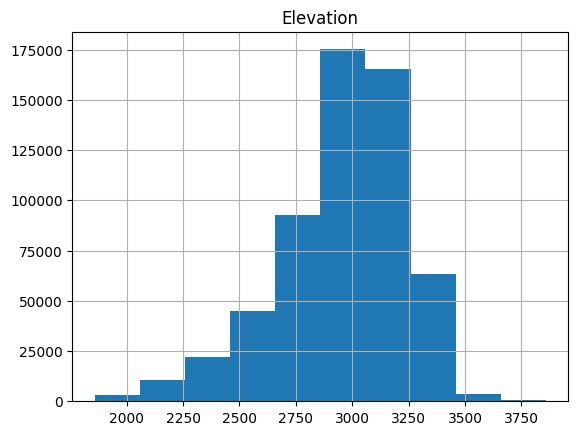

In [ ]:
import matplotlib.pyplot as plt

transformed_df = forest.select('Elevation')
transformed_df.toPandas().hist()

# plt.savefig('Elevation_histogram.png')

# plt.close('all')
plt.show()

In [ ]:
# The distribution is a bit skewed, but to a certain degree, we can assume that
# it follows a normal distribution. Thus, we can use family = 'gaussian'
# (default) and link = 'identity'.

## Selecting the most predictable features

In [ ]:
# 1-Chi-Square selector

vectorAssembler = feat.VectorAssembler(inputCols=forest.columns[0:-1]
    , outputCol='features' )

selector = feat.ChiSqSelector(
    labelCol='CoverType', numTopFeatures=10, outputCol='selected')

pipeline_sel = Pipeline(stages=[vectorAssembler, selector])

(
    pipeline_sel
    .fit(forest)
    .transform(forest)
    .select(selector.getOutputCol())
    .show(5)
)

+--------------------+
|            selected|
+--------------------+
|(10,[0,1,2,3,5,6,...|
|(10,[0,1,2,3,4,5,...|
|(10,[0,1,2,3,4,5,...|
|(10,[0,1,2,3,4,5,...|
|(10,[0,1,2,3,4,5,...|
+--------------------+
only showing top 5 rows



In [ ]:
# That code that will help to select the top 10 features with the
# most predictive power to find the best class for an observation in our forest
# DataFrame

# we use the .ChiSqSelector(...) method to select the best features based
# on the pairwise chi-square test between each variable and the target. Based
# on the values from the test, numTopFeatures, the most predictable features, are
# selected. The selected vector will contain the top 10 (in this case) most
# predictable features. The labelCol specifies the target column.

In [ ]:
# 2 -Correlation matrix

import pyspark.ml.stat as st

features_and_label = feat.VectorAssembler(
    inputCols=forest.columns, outputCol='features'
)

corr = st.Correlation.corr(
    features_and_label.transform(forest), 'features', 'pearson')

print(str(corr.collect()[0][0]))


DenseMatrix([[ 1.        ,  0.01573494, -0.24269664, ...,  0.19359464,
               0.21261232, -0.26955378],
             [ 0.01573494,  1.        ,  0.07872841, ...,  0.00829428,
              -0.00586558,  0.0170798 ],
             [-0.24269664,  0.07872841,  1.        , ...,  0.09360193,
               0.02563691,  0.14828541],
             ...,
             [ 0.19359464,  0.00829428,  0.09360193, ...,  1.        ,
              -0.01929168,  0.15566826],
             [ 0.21261232, -0.00586558,  0.02563691, ..., -0.01929168,
               1.        ,  0.1283513 ],
             [-0.26955378,  0.0170798 ,  0.14828541, ...,  0.15566826,
               0.1283513 ,  1.        ]])


In [ ]:
corr

DataFrame[pearson(features): matrix]

In [ ]:
#################### Visualize the correlation matrix ######################
############################################################################

In [ ]:
# # Collect the correlation matrix
# corr_matrix = corr.head()[0]

In [ ]:
# import numpy as np
# import pandas as pd

# # Convert Sparse Matrix to Dense
# dense_corr_matrix = corr_matrix.toArray()

# # Get the feature names (excluding the target)
# feature_names = forest.columns

# # Convert the dense matrix to a Pandas DataFrame
# corr_df = pd.DataFrame(dense_corr_matrix, columns=feature_names, index=feature_names)


In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Plot the correlation matrix using Seaborn
# plt.figure(figsize=(12, 8))
# sns.heatmap(corr_df, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)

# # Set labels and title
# plt.title("Feature Correlation Matrix")
# plt.show()


In [ ]:
# Extract the top 10 most correlated features with our label.

num_of_features = 10
cols = dict([ (i, e) for i, e in enumerate(forest.columns) ])

corr_matrix = corr.collect()[0][0]
label_corr_with_idx = [(i[0], e) for i, e in np.ndenumerate(corr_matrix.toArray()[:,0]) ][1:]

label_corr_with_idx_sorted = sorted(
    label_corr_with_idx
    , key=lambda el: -abs(el[1])
)

features_selected = np.array([
    cols[el[0]]
    for el
    in label_corr_with_idx_sorted
])[0:num_of_features]

features_selected

array(['Wilderness_Area_CacheLaPoudre', 'Soil_type_4703',
       'Horizontal_Distance_To_Roadways',
       'Horizontal_Distance_To_Hydrology', 'CoverType', 'Slope',
       'Wilderness_Area_Neota', 'Soil_type_8771', 'Soil_type_2717',
       'Soil_type_8776'], dtype='<U34')

In [ ]:
# First, we specify the number of features we want to extract and create a
# dictionary with all the columns from our forest DataFrame; note that we
# ZIP it with the index as the correlation matrix does not propagate the
# feature names, only the indices.

# Next, we extract the first column from the corr_matrix (as this is our target,
# the Elevation feature); the .toArray() method converts a DenseMatrix to a
# NumPy array representation. Note that we also append the index to the
# elements of this array so we know which element is most correlated with
# our target.

In [ ]:
# Next, we sort the list in descending order by looking at the absolute values
# of the correlation coefficient.

# Finally, we loop through the top 10 (in this case) elements of the resulting
# list and select the column from the cols dictionary that corresponds with the
# selected index.

## Classification Problem

#### Predicting forest coverage types

In [ ]:
# we will process data and build two classification
# models that aim to forecast the forest coverage type: the benchmark logistic
# regression model and the random forest classifier.

In [ ]:
##################### 1- Logistic Regression model #############################
################################################################################

# split the data we have into two subsets: the first one, forest_train,
# we will use for training the model, while forest_test will be used for testing
# the performance of the model.
forest_train, forest_test = (
    forest.randomSplit([0.7, 0.3], seed=666) )

vectorAssembler = feat.VectorAssembler(
    inputCols=forest.columns[0:-1], outputCol='features' )

selector = feat.ChiSqSelector(
    labelCol='CoverType', numTopFeatures=10, outputCol='selected' )

# use the
# elastic-net type of regularization in this model: the L2 portion is defined in
# the regParam parameter, and the L1 portion in elasticNetParam. Note that we
# specify the family of the model to be multinomial as we are dealing with a
# multinomial classification problem.

logReg_obj = cl.LogisticRegression(
    labelCol='CoverType', featuresCol=selector.getOutputCol(), regParam=0.01
    , elasticNetParam=1.0, family='multinomial'
)

# Finally, we build the Pipeline and pass the three objects as the list of stages.
# Next, we push our data through the pipeline using the .fit(...) method.
pipeline = Pipeline(
    stages=[
        vectorAssembler, selector, logReg_obj ])

pModel = pipeline.fit(forest_train)

In [ ]:
pModel

PipelineModel_b9db8cfaf116

In [ ]:
###Performance of the model

In [ ]:
import pyspark.ml.evaluation as ev

results_logReg = (
    pModel
    .transform(forest_test)
    .select('CoverType', 'probability', 'prediction')
)

evaluator = ev.MulticlassClassificationEvaluator(
    predictionCol='prediction'
    , labelCol='CoverType')

(
    evaluator.evaluate(results_logReg)
    , evaluator.evaluate(
        results_logReg
        , {evaluator.metricName: 'weightedPrecision'}
    )
    , evaluator.evaluate(
        results_logReg
        , {evaluator.metricName: 'accuracy'}
    )
)

(0.652789360337287, 0.6396702269113369, 0.6823486234323299)

In [ ]:
##################### 2- Random Forest model #############################
################################################################################

rf_obj = cl.RandomForestClassifier(
    labelCol='CoverType', featuresCol=selector.getOutputCol(), minInstancesPerNode=10
    , numTrees=10
)

pipeline = Pipeline(
    stages=[vectorAssembler, selector, rf_obj])

pModel = pipeline.fit(forest_train)

results_rf = (
    pModel
    .transform(forest_test)
    .select('CoverType', 'probability', 'prediction') )

evaluator = ev.MulticlassClassificationEvaluator(
    predictionCol='prediction'
    , labelCol='CoverType')

(
    evaluator.evaluate(results_rf)
    , evaluator.evaluate(
        results_rf
        , {evaluator.metricName: 'weightedPrecision'}
    )
    , evaluator.evaluate(
        results_rf
        , {evaluator.metricName: 'accuracy'}
    )
)

(0.6571954711234642, 0.6640165121772772, 0.6866667048966929)

In [ ]:
## Estimation of random forest for elevation column
vectorAssembler = feat.VectorAssembler(
    inputCols=forest.columns[1:]
    , outputCol='features')

rf_obj = rg.RandomForestRegressor(
    labelCol='Elevation', maxDepth=10, minInstancesPerNode=10, minInfoGain=0.1, numTrees=10
)

pip = Pipeline(stages=[vectorAssembler, rf_obj])

results = (
    pip
    .fit(forest)
    .transform(forest)
    .select('Elevation', 'prediction')
)

evaluator = ev.RegressionEvaluator(labelCol='Elevation')
evaluator.evaluate(results, {evaluator.metricName: 'r2'})

0.8317143469868216

In [ ]:
################# 3-Gradient Boosted Trees regression

gbt_obj = rg.GBTRegressor(
    labelCol='Elevation', minInstancesPerNode=10, minInfoGain=0.1 )

pip = Pipeline(stages=[vectorAssembler, gbt_obj])

results = (
    pip
    .fit(forest)
    .transform(forest)
    .select('Elevation', 'prediction')
)

evaluator = ev.RegressionEvaluator(labelCol='Elevation')
evaluator.evaluate(results, {evaluator.metricName: 'r2'})

0.8316069775965103

## Clustering forest cover types

In [ ]:
import pyspark.ml.clustering as clust

vectorAssembler = feat.VectorAssembler(
    inputCols=forest.columns[:-1]
    , outputCol='features')

kmeans_obj = clust.KMeans(k=7, seed=666)

pip = Pipeline(stages=[vectorAssembler, kmeans_obj])

In [ ]:
pip

Pipeline_ea929df87cd7

In [ ]:
results = (
    pip
    .fit(forest)
    .transform(forest)
    .select('features', 'CoverType', 'prediction')
)

results.show(5)

+--------------------+---------+----------+
|            features|CoverType|prediction|
+--------------------+---------+----------+
|(54,[0,1,2,3,5,6,...|        5|         0|
|(54,[0,1,2,3,4,5,...|        5|         0|
|(54,[0,1,2,3,4,5,...|        2|         1|
|(54,[0,1,2,3,4,5,...|        2|         1|
|(54,[0,1,2,3,4,5,...|        5|         0|
+--------------------+---------+----------+
only showing top 5 rows



In [ ]:
clustering_ev = ev.ClusteringEvaluator()
clustering_ev.evaluate(results)

0.5010954680164504

# Hyperparameter Tuning

In [ ]:
################# Grid Search ##########################

# We start with grid search. It is a brute-force method that simply loops
# through specific values of parameters, building new models and comparing
# their performance given some objective evaluator:

In [ ]:
import pyspark.ml.tuning as tune

vectorAssembler = feat.VectorAssembler(
    inputCols=forest.columns[0:-1], outputCol='features')

selector = feat.ChiSqSelector(
    labelCol='CoverType', numTopFeatures=5, outputCol='selected')

logReg_obj = cl.LogisticRegression(
    labelCol='CoverType', featuresCol=selector.getOutputCol(), family='multinomial')

logReg_grid = (
    tune.ParamGridBuilder()
    .addGrid(logReg_obj.regParam
            , [0.01, 0.1]
        )
    .addGrid(logReg_obj.elasticNetParam
            , [1.0, 0.5]
        )
    .build()
)

logReg_ev = ev.MulticlassClassificationEvaluator(
    predictionCol='prediction', labelCol='CoverType')

cross_v = tune.CrossValidator(
    estimator=logReg_obj, estimatorParamMaps=logReg_grid, evaluator=logReg_ev)

pipeline = Pipeline(stages=[vectorAssembler, selector])
data_trans = pipeline.fit(forest_train)

logReg_modelTest = cross_v.fit(
    data_trans.transform(forest_train)
)


In [ ]:
data_trans_test = data_trans.transform(forest_test)
results = logReg_modelTest.transform(data_trans_test)

print(logReg_ev.evaluate(results, {logReg_ev.metricName: 'weightedPrecision'}))
print(logReg_ev.evaluate(results, {logReg_ev.metricName: 'weightedRecall'}))
print(logReg_ev.evaluate(results, {logReg_ev.metricName: 'accuracy'}))

0.632360035075164
0.6737124605036041
0.6737124605036041


In [ ]:
# As you can see, we do slightly worse than the previous model, but this is
# most likely due to the fact that we only selected the top 5 (versus 10 before)
# features with our selector.

Another approach that aims at finding the best performing model is called train-validation split.

This method performs a split of the training data into
two smaller subsets: one that is use to train the model, and another one thatis used to validate whether the model is not overfitting.

The split is onlyperformed once, thus in contrast to cross-validation, it is less expensive:

In [ ]:
######## Train validation splitting


train_v = tune.TrainValidationSplit(
    estimator=logReg_obj
    , estimatorParamMaps=logReg_grid
    , evaluator=logReg_ev
    , parallelism=4
)

logReg_modelTrainV = (
    train_v
    .fit(data_trans.transform(forest_train)))

results = logReg_modelTrainV.transform(data_trans_test)

print(logReg_ev.evaluate(results, {logReg_ev.metricName: 'weightedPrecision'}))
print(logReg_ev.evaluate(results, {logReg_ev.metricName: 'weightedRecall'}))
print(logReg_ev.evaluate(results, {logReg_ev.metricName: 'accuracy'}))

0.632360035075164
0.6737124605036041
0.6737124605036041


In [ ]:
# The preceding code is not that dissimilar from what we saw
# with .CrossValidator(...). The only additional parameter we specify for the
# .TrainValidationSplit(...) method is the level of parallelism that controls how
# many threads are spun up when you select the best model.

# Text analysis

In [ ]:
#################### FEATURE ENGINEERING - NLP ########################
########################################################################
##########################################################################
##########################################################################

In [ ]:
some_text = spark.createDataFrame([
    ['''
    Apache Spark achieves high performance for both batch
    and streaming data, using a state-of-the-art DAG scheduler,
    a query optimizer, and a physical execution engine.
    ''']
    , ['''
    Apache Spark is a fast and general-purpose cluster computing
    system. It provides high-level APIs in Java, Scala, Python
    and R, and an optimized engine that supports general execution
    graphs. It also supports a rich set of higher-level tools including
    Spark SQL for SQL and structured data processing, MLlib for machine
    learning, GraphX for graph processing, and Spark Streaming.
    ''']
    , ['''
    Machine learning is a field of computer science that often uses
    statistical techniques to give computers the ability to "learn"
    (i.e., progressively improve performance on a specific task)
    with data, without being explicitly programmed.
    ''']
], ['text'])

In [ ]:
### TOKENIZATION
splitter = feat.RegexTokenizer(
    inputCol='text'
    , outputCol='text_split'
    , pattern='\s+|[,.\"]'
)

splitter.transform(some_text).select('text_split').take(1)

[Row(text_split=['apache', 'spark', 'achieves', 'high', 'performance', 'for', 'both', 'batch', 'and', 'streaming', 'data', 'using', 'a', 'state-of-the-art', 'dag', 'scheduler', 'a', 'query', 'optimizer', 'and', 'a', 'physical', 'execution', 'engine'])]

In [ ]:
########## Removing Stop-words

sw_remover = feat.StopWordsRemover(
    inputCol=splitter.getOutputCol()
    , outputCol='no_stopWords'
)

sw_remover.transform(splitter.transform(some_text)).select('no_stopWords').take(1)

[Row(no_stopWords=['apache', 'spark', 'achieves', 'high', 'performance', 'batch', 'streaming', 'data', 'using', 'state-of-the-art', 'dag', 'scheduler', 'query', 'optimizer', 'physical', 'execution', 'engine'])]

In [ ]:
############ Hashing trick

hasher = feat.HashingTF(
    inputCol=sw_remover.getOutputCol()
    , outputCol='hashed'
    , numFeatures=20
)

hasher.transform(sw_remover.transform(splitter.transform(some_text))).select('hashed').take(1)

[Row(hashed=SparseVector(20, {0: 1.0, 2: 1.0, 3: 1.0, 6: 1.0, 8: 2.0, 9: 1.0, 11: 1.0, 12: 1.0, 13: 1.0, 15: 2.0, 16: 2.0, 17: 2.0, 18: 1.0}))]

In [ ]:
############ Term Frequency-Inverse Document Frequency

idf = feat.IDF(
    inputCol=hasher.getOutputCol()
    , outputCol='features'
)

idfModel = idf.fit(hasher.transform(sw_remover.transform(splitter.transform(some_text))))
idfModel.transform(hasher.transform(sw_remover.transform(splitter.transform(some_text)))).select('features').take(1)


[Row(features=SparseVector(20, {0: 0.0, 2: 0.2877, 3: 0.0, 6: 0.2877, 8: 0.0, 9: 0.2877, 11: 0.2877, 12: 0.0, 13: 0.0, 15: 0.0, 16: 0.0, 17: 1.3863, 18: 0.6931}))]

In [ ]:
pipeline = Pipeline(stages=[splitter, sw_remover, hasher, idf])

pipelineModel = pipeline.fit(some_text)
pipelineModel.transform(some_text).select('text','features').take(1)

[Row(text='\n    Apache Spark achieves high performance for both batch\n    and streaming data, using a state-of-the-art DAG scheduler, \n    a query optimizer, and a physical execution engine.\n    ', features=SparseVector(20, {0: 0.0, 2: 0.2877, 3: 0.0, 6: 0.2877, 8: 0.0, 9: 0.2877, 11: 0.2877, 12: 0.0, 13: 0.0, 15: 0.0, 16: 0.0, 17: 1.3863, 18: 0.6931}))]

In [ ]:
############# Word-2-Vec model
w2v = feat.Word2Vec(
    vectorSize=5
    , minCount=2
    , inputCol=sw_remover.getOutputCol()
    , outputCol='vector'
)

model=w2v.fit(sw_remover.transform(splitter.transform(some_text)))
model.transform(sw_remover.transform(splitter.transform(some_text))).select('vector').take(1)

[Row(vector=DenseVector([0.0008, 0.0041, 0.0044, 0.0029, -0.0078]))]

In [ ]:
############ Discretizing continuous variables

In [ ]:
signal_df = spark.read.csv('/content/drive/My Drive/Pyspark/data/fourier_signal.csv', header=True, inferSchema=True)

steps = feat.QuantileDiscretizer(
       numBuckets=10,
       inputCol='signal',
       outputCol='discretized')

transformed = (
    steps
    .fit(signal_df)
    .transform(signal_df)
)

In [ ]:
signal_df.head()

Row(signal=0.5233399378711634)

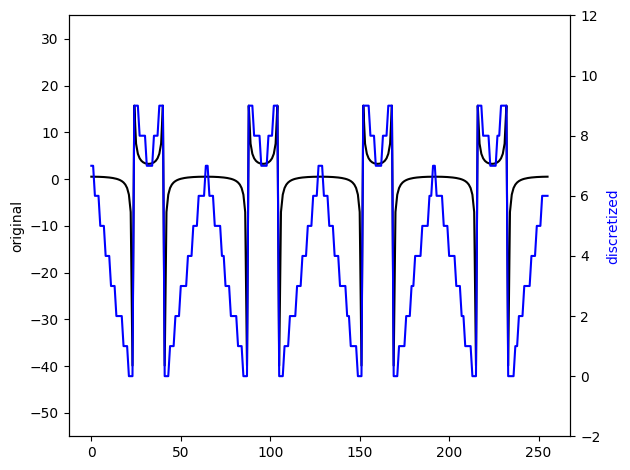

In [ ]:
import matplotlib.pyplot as plt

transformed_df = transformed.toPandas()

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(transformed_df['signal'], 'k')
ax2.plot(transformed_df['discretized'], 'b-')

ax1.set_ylabel('original', color='k')
ax2.set_ylabel('discretized', color='b')

ax1.set_ylim((-55, 35))
ax2.set_ylim((-2, 12))
fig.tight_layout()

# plt.savefig('discretized.png')

# plt.close('all')

plt.show()

In [ ]:
################Standardizing continuous variables
signal_df.describe().show()


+-------+--------------------+
|summary|              signal|
+-------+--------------------+
|  count|                 256|
|   mean|-5.59448321002520...|
| stddev|   8.056325329550202|
|    min|    -39.878842775021|
|    max|  15.718058116309553|
+-------+--------------------+



In [ ]:
from pyspark.ml import Pipeline
vec = feat.VectorAssembler(
    inputCols=['signal']
    , outputCol='signal_vec'
)

norm = feat.StandardScaler(
    inputCol=vec.getOutputCol()
    , outputCol='signal_norm'
    , withMean=True
    , withStd=True
)

norm_pipeline = Pipeline(stages=[vec, norm])
signal_norm = (
    norm_pipeline
    .fit(signal_df)
    .transform(signal_df)
)

signal_norm.take(1)

[Row(signal=0.5233399378711634, signal_vec=DenseVector([0.5233]), signal_norm=DenseVector([0.065]))]

<ipython-input-85-23702e278e67>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  normalized_df['normalized'] = normalized_df.apply(lambda row: row[2][0], axis=1)


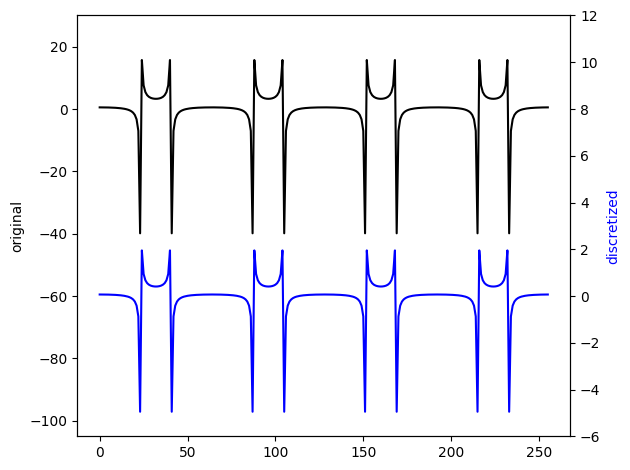

In [ ]:
normalized_df = signal_norm.toPandas()
normalized_df['normalized'] = normalized_df.apply(lambda row: row[2][0], axis=1)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(normalized_df['signal'], 'k')
ax2.plot(normalized_df['normalized'], 'b-')

ax1.set_ylabel('original', color='k')
ax2.set_ylabel('discretized', color='b')

ax1.set_ylim((-105, 30))
ax2.set_ylim((-6, 12))
fig.tight_layout()

plt.show()

In [ ]:
##########Topic mining

articles = spark.createDataFrame([
    ('''
        The Andromeda Galaxy, named after the mythological
        Princess Andromeda, also known as Messier 31, M31,
        or NGC 224, is a spiral galaxy approximately 780
        kiloparsecs (2.5 million light-years) from Earth,
        and the nearest major galaxy to the Milky Way.
        Its name stems from the area of the sky in which it
        appears, the constellation of Andromeda. The 2006
        observations by the Spitzer Space Telescope revealed
        that the Andromeda Galaxy contains approximately one
        trillion stars, more than twice the number of the
        Milky Way’s estimated 200-400 billion stars. The
        Andromeda Galaxy, spanning approximately 220,000 light
        years, is the largest galaxy in our Local Group,
        which is also home to the Triangulum Galaxy and
        other minor galaxies. The Andromeda Galaxy's mass is
        estimated to be around 1.76 times that of the Milky
        Way Galaxy (~0.8-1.5×1012 solar masses vs the Milky
        Way's 8.5×1011 solar masses).
    ''','Galaxy', 'Andromeda')
    , ('''
        The Milky Way is the galaxy that contains our Solar
        System. The descriptive "milky" is derived from the
        appearance from Earth of the galaxy – a band of light
        seen in the night sky formed from stars that cannot be
        individually distinguished by the naked eye. The term
        Milky Way is a translation of the Latin via lactea, from
        the Greek. From Earth, the Milky Way appears as a band
        because its disk-shaped structure is viewed from within.
        Galileo Galilei first resolved the band of light into
        individual stars with his telescope in 1610. Observations
        by Edwin Hubble showed that the Milky
        Way is just one of many galaxies.
    ''','Galaxy','Milky Way')
    , ('''
        Australia, officially the Commonwealth of Australia,
        is a sovereign country comprising the mainland of the
        Australian continent, the island of Tasmania and numerous
        smaller islands. It is the largest country in Oceania and
        the world's sixth-largest country by total area. The
        neighbouring countries are Papua New Guinea, Indonesia and
        East Timor to the north; the Solomon Islands and Vanuatu to
        the north-east; and New Zealand to the south-east. Australia's
        capital is Canberra, and its largest city is Sydney.
    ''','Geography', 'Australia')
    , ('''
        The United States of America (USA), commonly known as the United
        States (U.S.) or America, is a federal republic composed of 50
        states, a federal district, five major self-governing territories,
        and various possessions. At 3.8 million square miles (9.8 million
        km2) and with over 325 million people, the United States is the
        world's third- or fourth-largest country by total area and the
        third-most populous country. The capital is Washington, D.C., and
        the largest city by population is New York City. Forty-eight states
        and the capital's federal district are contiguous and in North America
        between Canada and Mexico. The State of Alaska is in the northwest
        corner of North America, bordered by Canada to the east and across
        the Bering Strait from Russia to the west. The State of Hawaii is
        an archipelago in the mid-Pacific Ocean. The U.S. territories are
        scattered about the Pacific Ocean and the Caribbean Sea, stretching
        across nine official time zones. The extremely diverse geography,
        climate, and wildlife of the United States make it one of the world's
        17 megadiverse countries.
    ''','Geography', 'USA')
    , ('''
        China, officially the People's Republic of China (PRC), is a unitary
        sovereign state in East Asia and, with a population of around 1.404
        billion, the world's most populous country. Covering 9,600,000
        square kilometers (3,700,000 sq mi), China has the most borders of
        any country in the world. Governed by the Communist Party of China,
        it exercises jurisdiction over 22 provinces, five autonomous regions,
        four direct-controlled municipalities (Beijing, Tianjin, Shanghai, and
        Chongqing), and the special administrative regions of Hong Kong and Macau.
    ''','Geography', 'China')
    , ('''
        Poland, officially the Republic of Poland, is a country located in
        Central Europe. It is divided into 16 administrative subdivisions,
        covering an area of 312,679 square kilometres (120,726 sq mi), and has
        a largely temperate seasonal climate. With a population of approximately
        38.5 million people, Poland is the sixth most populous member state of
        the European Union. Poland's capital and largest metropolis is
        Warsaw.
    ''','Geography', 'Poland')
    , ('''
        The domestic dog (Canis lupus familiaris when considered a subspecies
        of the gray wolf or Canis familiaris when considered a distinct species)
        is a member of the genus Canis (canines), which forms part of the
        wolf-like canids, and is the most widely abundant terrestrial carnivore.
        The dog and the extant gray wolf are sister taxa as modern wolves are
        not closely related to the wolves that were first domesticated, which
        implies that the direct ancestor of the dog is extinct. The dog was
        the first species to be domesticated and has been selectively bred over
        millennia for various behaviors, sensory capabilities, and physical attributes.
    ''','Animal', 'Dog')
    , ('''
        The origin of the domestic dog is not clear. It is known that the dog was
        the first domesticated species. The domestic dog is a member of the genus
        Canis (canines), which forms part of the wolf-like canids, and is the most
        widely abundant terrestrial carnivore. The closest living relative of the
        dog is the gray wolf and there is no evidence of any other canine
        contributing to its genetic lineage. The dog and the extant gray wolf
        form two sister clades, with modern wolves not closely related to the
        wolves that were first domesticated. The archaeological record shows
        the first undisputed dog remains buried beside humans 14,700 years ago,
        with disputed remains occurring 36,000 years ago. These dates imply
        that the earliest dogs arose in the time of human hunter-gatherers
        and not agriculturists.
    ''','Animal', 'Dog')
    , ('''
        Washington, officially the State of Washington, is a state in the Pacific
        Northwest region of the United States. Named after George Washington,
        the first president of the United States, the state was made out of the
        western part of the Washington Territory, which was ceded by Britain in
        1846 in accordance with the Oregon Treaty in the settlement of the
        Oregon boundary dispute. It was admitted to the Union as the 42nd state
        in 1889. Olympia is the state capital. Washington is sometimes referred
        to as Washington State, to distinguish it from Washington, D.C., the
        capital of the United States, which is often shortened to Washington.
    ''','Geography', 'Washington State')
], ['articles', 'Topic', 'Object'])

In [ ]:
import pyspark.ml.clustering as clust

splitter = feat.RegexTokenizer(
    inputCol='articles'
    , outputCol='articles_split'
    , pattern='\s+|[,.\"]'
)

sw_remover = feat.StopWordsRemover(
    inputCol=splitter.getOutputCol()
    , outputCol='no_stopWords'
)

count_vec = feat.CountVectorizer(
    inputCol=sw_remover.getOutputCol()
    , outputCol='vector'
)

lda_clusters = clust.LDA(
    k=3
    , optimizer='online'
    , featuresCol=count_vec.getOutputCol()
)

topic_pipeline = Pipeline(
    stages=[
        splitter
        , sw_remover
        , count_vec
        , lda_clusters
    ]
)

for topic in (
        topic_pipeline
        .fit(articles)
        .transform(articles)
        .select('Topic','Object','topicDistribution')
        .take(10)
):
    print(
        topic.Topic
        , topic.Object
        , np.argmax(topic.topicDistribution)
        , topic.topicDistribution
    )

Galaxy Andromeda 0 [0.993955771720572,0.0034275054979056576,0.0026167227815222676]
Galaxy Milky Way 0 [0.9908637470743492,0.005097440047844919,0.004038812877805849]
Geography Australia 1 [0.005617177714786821,0.9887678103345171,0.005615011950696117]
Geography USA 1 [0.0022018865145151576,0.9956105199617746,0.002187593523710123]
Geography China 2 [0.004355858012103728,0.005912317475182235,0.9897318245127141]
Geography Poland 2 [0.005573184539726357,0.007533094882000663,0.9868937205782731]
Animal Dog 0 [0.9901708192523013,0.005516389112890071,0.004312791634808563]
Animal Dog 0 [0.9926739267407928,0.004144797649719265,0.00318127560948804]
Geography Washington State 1 [0.00433930551856544,0.9913643146312879,0.004296379850146538]
